In [1]:
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [37]:
data = pd.read_csv('final_f1_1990.csv')

# dummy = data['constructorRef'].str.get_dummies(" ")
# dummy.columns = 'constructor_' + dummy.columns

dummy2 = data['circuitRef'].str.get_dummies(" ")
dummy2.columns = 'circuit_' + dummy2.columns

# data = pd.concat([data, dummy], axis=1)
data = pd.concat([data, dummy2], axis=1)
print(data.head())

   year  round    alt  driverId driverRef  driver_points  \
0  1991      1  345.0       131    modena            3.0   
1  1991      1  345.0       127  gugelmin            0.0   
2  1991      1  345.0        95   mansell            0.0   
3  1991      1  345.0        99  tarquini            0.0   
4  1991      1  345.0       102     senna           10.0   

   driver_standings_pos  driver_wins  grid  Podium  ... circuit_shanghai  \
0                     4            0    11       4  ...                0   
1                    21            0    23       0  ...                0   
2                    20            0     4       0  ...                0   
3                     8            0    22       8  ...                0   
4                     1            1     1       1  ...                0   

  circuit_silverstone  circuit_sochi  circuit_spa  circuit_suzuka  \
0                   0              0            0               0   
1                   0              0        

In [38]:
# Change seconds to minutes so it's easier to interpret

data['minutes'] = round((data['seconds'] / 60), 2)
data.drop('seconds', axis=1, inplace=True)
print(data.head())

   year  round    alt  driverId driverRef  driver_points  \
0  1991      1  345.0       131    modena            3.0   
1  1991      1  345.0       127  gugelmin            0.0   
2  1991      1  345.0        95   mansell            0.0   
3  1991      1  345.0        99  tarquini            0.0   
4  1991      1  345.0       102     senna           10.0   

   driver_standings_pos  driver_wins  grid  Podium  ... circuit_silverstone  \
0                     4            0    11       4  ...                   0   
1                    21            0    23       0  ...                   0   
2                    20            0     4       0  ...                   0   
3                     8            0    22       8  ...                   0   
4                     1            1     1       1  ...                   0   

  circuit_sochi  circuit_spa  circuit_suzuka  circuit_valencia  \
0             0            0               0                 0   
1             0            0    

In [39]:
#get rid of unnecessary columns
del data['constructorRef']
del data['circuitRef']
data = data.drop(['driverRef'], axis = 1)
print(data.head())

   year  round    alt  driverId  driver_points  driver_standings_pos  \
0  1991      1  345.0       131            3.0                     4   
1  1991      1  345.0       127            0.0                    21   
2  1991      1  345.0        95            0.0                    20   
3  1991      1  345.0        99            0.0                     8   
4  1991      1  345.0       102           10.0                     1   

   driver_wins  grid  Podium  circuit_adelaide  ...  circuit_silverstone  \
0            0    11       4                 0  ...                    0   
1            0    23       0                 0  ...                    0   
2            0     4       0                 0  ...                    0   
3            0    22       8                 0  ...                    0   
4            1     1       1                 0  ...                    0   

   circuit_sochi  circuit_spa  circuit_suzuka  circuit_valencia  \
0              0            0              

In [40]:
# Create df without dummy variables for EDA
eda = data.filter(['year', 'round', 'alt', 'driverId', 
                   'driver_points', 'driver_standings_pos', 'driver_wins', 
                   'grid', 'Podium', 'minutes'], axis=1)
print(eda.shape)

(12418, 10)


In [41]:
# Delete outliers
eda = eda[eda['grid'] <= 20]
eda = eda[eda['grid'] > 0]
eda = eda[eda['Podium'] <= 20]
eda = eda[eda['minutes'] <= 160]
eda = eda[eda['driver_standings_pos'] <= 40]
print(eda.shape)

(11104, 10)


In [42]:
# Join data back with dummies

df = pd.merge(eda, data, on=['year', 'round', 'alt', 'driverId', 
                   'driver_points', 'driver_standings_pos', 'driver_wins', 
                   'grid', 'Podium', 'minutes'], how='left')
print(df.shape)


(11104, 55)


In [65]:
X = df[df['year'] < 2022][["year", "driverId", "driver_points", "driver_standings_pos", "driver_wins", "grid"]]
y = df[df['year'] < 2022][["Podium"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_2022 = df[df['year'] == 2022][["year", "driverId", "driver_points", "driver_standings_pos", "driver_wins", "grid"]]
y_test_2022 = df[df['year'] == 2022][["Podium"]]

In [66]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8554, 6)
(2139, 6)
(8554, 1)
(2139, 1)


In [67]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [68]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])


    model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return model


In [69]:
# K-fold cross validation

k = 4
num_val_samples = len(X_train) // k
# num_epochs = 200
# all_scores = []
# for i in range(k):
#     print(f"Processing fold #{i}")
#     val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
#     val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
#     partial_train_data = np.concatenate(
#         [X_train[:i * num_val_samples],
#          X_train[(i + 1) * num_val_samples:]],
#         axis=0)
#     partial_train_targets = np.concatenate(
#         [y_train[:i * num_val_samples],
#          y_train[(i + 1) * num_val_samples:]],
#         axis=0)
#     model = build_model()
#     model.fit(partial_train_data, partial_train_targets,
#               epochs=num_epochs, batch_size=16, verbose=0)
#     val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
#     all_scores.append(val_mae)


# all_scores
# np.mean(all_scores)

# Saving the validation logs at each fold

num_epochs = 40
all_acc_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    acc_history = history.history["val_accuracy"]
    all_acc_histories.append(acc_history)


# Building the history of successive mean K-fold validation scores

average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

Processing fold #0


2023-05-17 00:51:28.678145: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-17 00:51:29.008553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 00:51:32.289666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Processing fold #1


2023-05-17 00:53:15.681269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 00:53:18.236003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Processing fold #2


2023-05-17 00:54:58.372303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 00:55:00.791612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Processing fold #3


2023-05-17 00:56:40.962745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 00:56:43.442076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


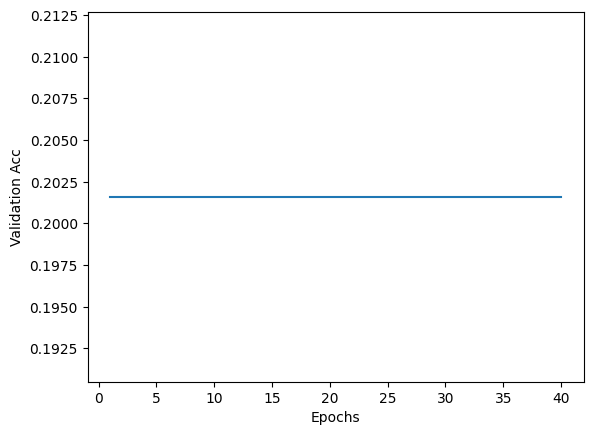

In [70]:
# Plotting validation scores

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Acc")
plt.show()

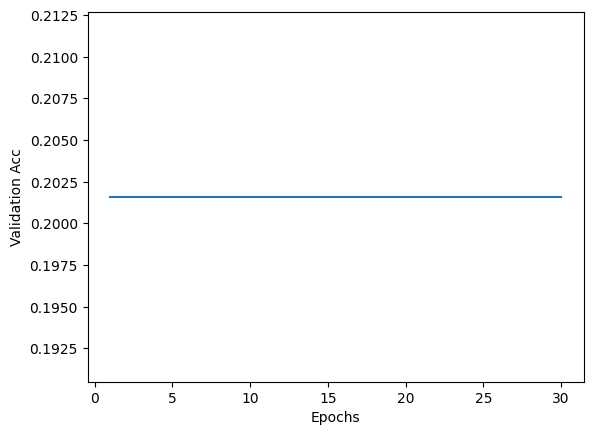

In [71]:
# Plotting validation scores, excluding the first 10 data points

truncated_acc_history = average_acc_history[10:]
plt.plot(range(1, len(truncated_acc_history) + 1), truncated_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Acc")
plt.show() 

In [72]:
# Training the final model

model = build_model()
model.fit(X_train, y_train,
          epochs=100, batch_size=20, verbose=0)
test_loss_score, test_acc_score = model.evaluate(y_train_2022, y_test_2022)

test_acc_score

2023-05-17 01:00:02.645693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 9ms/step - loss: 9.0756e-07 - accuracy: 0.1533


2023-05-17 01:02:16.328086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.15328466892242432

In [74]:
model.predict(y_train_2022)

13/13 [==============================] - 0s 4ms/step


2023-05-17 01:06:33.184613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[-262.44858],
       [-262.999  ],
       [-261.6641 ],
       [-262.55328],
       [-262.6644 ],
       [-261.61118],
       [-262.9544 ],
       [-262.51694],
       [-256.15454],
       [-262.407  ],
       [-262.82986],
       [-262.43448],
       [-262.16382],
       [-262.39417],
       [-263.53314],
       [-262.26678],
       [-262.9713 ],
       [-262.4365 ],
       [-256.96918],
       [-262.43018],
       [-262.38205],
       [-263.03067],
       [-263.58353],
       [-262.51425],
       [-262.4131 ],
       [-262.21307],
       [-264.56738],
       [-262.9095 ],
       [-255.97003],
       [-262.407  ],
       [-263.17206],
       [-262.79242],
       [-262.43518],
       [-262.40717],
       [-265.43896],
       [-263.83453],
       [-262.99377],
       [-257.41608],
       [-262.71738],
       [-262.4008 ],
       [-263.03067],
       [-263.572  ],
       [-262.6991 ],
       [-262.92413],
       [-264.16028],
       [-265.03522],
       [-263.8102 ],
       [-256.

In [43]:
print(df["circuit_monaco"])

0        0
1        0
2        0
3        0
4        0
        ..
11099    0
11100    0
11101    0
11102    0
11103    0
Name: circuit_monaco, Length: 11104, dtype: int64


In [44]:
df_monaco = df[df["circuit_monaco"] == 1]
print(df_monaco.shape)

#deleting all the dummy variables for circuit names as we'll be focusing on monaco
col_to_drop = [col for col in df_monaco.columns if col.startswith('circuit')]

# Drop the selected columns
for col in col_to_drop:
    df_monaco.drop(col, axis=1, inplace=True)


print(df_monaco.shape)

(613, 55)
(613, 10)


/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_28350/130632633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monaco.drop(col, axis=1, inplace=True)
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_28350/130632633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monaco.drop(col, axis=1, inplace=True)
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_28350/130632633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [1]:
model.preditct(df_monaco)


NameError: name 'model' is not defined

In [51]:
df_monaco.head()

,year,round,alt,driverId,driver_points,driver_standings_pos,driver_wins,grid,Podium,minutes
60,1991,4,7.0,131,3.0,11,0,2,0,0.00
61,1991,4,7.0,127,0.0,27,0,15,0,0.00
62,1991,4,7.0,95,6.0,5,0,5,2,113.34
63,1991,4,7.0,102,40.0,1,4,1,1,113.04
64,1991,4,7.0,77,10.0,3,0,6,0,0.00


In [54]:
# Splitting into train and test data

X_train = df_monaco[df_monaco['year'] < 2022][["year", "driverId", "driver_points", "driver_standings_pos", "driver_wins", "grid"]]
X_test = df_monaco[df_monaco['year'] < 2022][["Podium"]]
y_train = df_monaco[df_monaco['year'] == 2022][["year", "driverId", "driver_points", "driver_standings_pos", "driver_wins", "grid"]]
y_test = df_monaco[df_monaco['year'] == 2022][["Podium"]]
